In [5]:

import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

BASE_OUTPUT_DIR = "f1_results_by_type_simple" # Directory where your CSVs are stored
START_YEAR_DATA = 2024 # Assume data starts from this year
END_YEAR_DATA = 2024   # Assume data ends this year (adjust as per your scraped data)

# %%
def load_data(result_type, start_year, end_year, base_dir):
    """Loads and concatenates CSV files for a given result type and year range."""
    all_files = []
    for year in range(start_year, end_year + 1):
        pattern = os.path.join(base_dir, f"f1_{year}_{result_type}.csv")
        files = glob.glob(pattern)
        if not files:
            print(f"Warning: No {result_type} data found for year {year} in {base_dir}")
        for f in files:
            try:
                df = pd.read_csv(f)
                all_files.append(df)
            except pd.errors.EmptyDataError:
                print(f"Warning: Empty CSV file skipped: {f}")
            except Exception as e:
                print(f"Error loading {f}: {e}")
    
    if not all_files:
        print(f"No data loaded for {result_type}. Please check your OUTPUT_DIR and scraped years.")
        return pd.DataFrame()
        
    return pd.concat(all_files, ignore_index=True)

# Load race results and qualifying data
race_df = load_data('race', START_YEAR_DATA, END_YEAR_DATA, BASE_OUTPUT_DIR)
qualifying_df = load_data('qualifying', START_YEAR_DATA, END_YEAR_DATA, BASE_OUTPUT_DIR)

# %%
print("Race Data Sample:")
print(race_df.head())
print(f"\nRace Data Shape: {race_df.shape}")

print("\nQualifying Data Sample:")
print(qualifying_df.head())
print(f"\nQualifying Data Shape: {qualifying_df.shape}")





Race Data Sample:
   year                   race_name  race_id result_type  \
0  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   
1  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   
2  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   
3  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   
4  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   

                                                 url position  driver_number  \
0  https://www.formula1.com/en/results.html/2024/...        1              1   
1  https://www.formula1.com/en/results.html/2024/...        2             11   
2  https://www.formula1.com/en/results.html/2024/...        3             55   
3  https://www.formula1.com/en/results.html/2024/...        4             16   
4  https://www.formula1.com/en/results.html/2024/...        5             63   

  driver_code      driver_name                        team  laps  \
0         VER   Max Verstappen  Red Bull Racing Honda RBPT  57.0   
1   

In [6]:

if not qualifying_df.empty:
    qualifying_info_df = qualifying_df[['year', 'race_id', 'driver_name', 'driver_code', 'position', 'team']].copy()
    qualifying_info_df.rename(columns={'position': 'qualifying_position', 'team': 'qualifying_team'}, inplace=True)
    # Convert types if necessary
    qualifying_info_df['year'] = pd.to_numeric(qualifying_info_df['year'], errors='coerce')
    qualifying_info_df['race_id'] = pd.to_numeric(qualifying_info_df['race_id'], errors='coerce')
    qualifying_info_df['qualifying_position'] = pd.to_numeric(qualifying_info_df['qualifying_position'], errors='coerce')
else:
    print("Qualifying data is empty. Cannot proceed with merge.")
    qualifying_info_df = pd.DataFrame() # Ensure it's an empty DF

if not race_df.empty and not qualifying_info_df.empty:
    # Convert types in race_df for merging
    race_df['year'] = pd.to_numeric(race_df['year'], errors='coerce')
    race_df['race_id'] = pd.to_numeric(race_df['race_id'], errors='coerce')

    # Merge based on year, race_id, and driver_name.
    # Using driver_code might be more robust if available and consistent.
    merged_df = pd.merge(race_df, qualifying_info_df,
                         on=['year', 'race_id', 'driver_name', 'driver_code'], # Using both driver identifiers
                         suffixes=('_race', '_quali'),
                         how='left')
    # If qualifying_team was different from race team (e.g. mid-season transfer, rare)
    # we might have 'team_race' and 'qualifying_team'. For simplicity, we use 'team_race'.
    if 'team_race' in merged_df.columns:
      merged_df.rename(columns={'team_race': 'team'}, inplace=True)
    elif 'team' not in merged_df.columns and 'qualifying_team' in merged_df.columns:
      # if only quali team is there after merge due to column name in race_df
      merged_df.rename(columns={'qualifying_team': 'team'}, inplace=True)


    print("\nMerged Data Sample:")
    print(merged_df.head())
    print(f"\nMerged Data Shape: {merged_df.shape}")
else:
    print("Race or Qualifying data is empty. Merging skipped.")
    merged_df = pd.DataFrame()




Merged Data Sample:
   year                   race_name  race_id result_type  \
0  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   
1  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   
2  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   
3  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   
4  2024  FORMULA 1 GULF AIR BAHRAIN     1229        race   

                                                 url position  driver_number  \
0  https://www.formula1.com/en/results.html/2024/...        1              1   
1  https://www.formula1.com/en/results.html/2024/...        2             11   
2  https://www.formula1.com/en/results.html/2024/...        3             55   
3  https://www.formula1.com/en/results.html/2024/...        4             16   
4  https://www.formula1.com/en/results.html/2024/...        5             63   

  driver_code      driver_name                        team  laps  \
0         VER   Max Verstappen  Red Bull Racing Honda RBPT  57.0   
1

In [7]:

if not merged_df.empty:
    # --- Data Cleaning ---
    # Convert 'position' (race finish position) to numeric. Handle non-numeric like 'NC' (Not Classified) or 'DQ'
    # For simplicity, we'll map non-finishers to a high position number or NaN.
    merged_df['race_position_numeric'] = pd.to_numeric(merged_df['position'], errors='coerce')
    
    # For 'points', convert to numeric
    merged_df['points'] = pd.to_numeric(merged_df['points'], errors='coerce').fillna(0)

    # Handle missing qualifying positions (e.g., if a driver didn't set a time or data is missing)
    # We can fill with a high number (e.g., 25) or use mean/median if appropriate.
    # For now, let's fill with a value indicating they didn't qualify well or started from pit lane.
    merged_df['qualifying_position'].fillna(25, inplace=True) # Assuming max ~20-24 cars

    # --- Target Variable ---
    # Let's predict if a driver finishes in the points (Top 10)
    merged_df['points_finish'] = (merged_df['race_position_numeric'] <= 10).astype(int)

    # --- Feature Selection/Creation ---
    # Basic features:
    # - Qualifying position
    # - Driver (encoded)
    # - Team (encoded)
    # - Race/Track (encoded) - 'race_name' can represent the track

    # Drop rows with NaN in critical columns if any remain after filling
    critical_cols = ['qualifying_position', 'driver_name', 'team', 'race_name', 'points_finish', 'year']
    merged_df.dropna(subset=critical_cols, inplace=True)

    # Label Encoding for categorical features
    label_encoders = {}
    for col in ['driver_name', 'team', 'race_name', 'driver_code']: # Added driver_code
        if col in merged_df.columns:
            le = LabelEncoder()
            merged_df[col + '_encoded'] = le.fit_transform(merged_df[col])
            label_encoders[col] = le
        else:
            print(f"Warning: Column {col} not found for encoding.")


    # Define features (X) and target (y)
    # Ensure all selected features exist
    feature_columns = ['qualifying_position', 'driver_name_encoded', 'team_encoded', 'race_name_encoded']
    
    # Check if all feature columns are in merged_df
    final_feature_columns = [col for col in feature_columns if col in merged_df.columns]
    
    if len(final_feature_columns) != len(feature_columns):
        print(f"Warning: Some feature columns are missing. Using: {final_feature_columns}")

    if not final_feature_columns:
        print("Error: No feature columns available. Cannot proceed.")
        # Handle error appropriately, e.g., by exiting or raising an exception
        X = pd.DataFrame()
        y = pd.Series(dtype='int')
    else:
        X = merged_df[final_feature_columns]
        y = merged_df['points_finish']

    print("\nFeatures (X) Sample:")
    print(X.head())
    print("\nTarget (y) Sample:")
    print(y.head())

else:
    print("Merged data frame is empty. Preprocessing skipped.")
    X = pd.DataFrame()
    y = pd.Series(dtype='int')




Features (X) Sample:
   qualifying_position  driver_name_encoded  team_encoded  race_name_encoded
0                  1.0                   15             8                  7
1                  5.0                   20             8                  7
2                  4.0                    1             2                  7
3                  2.0                    2             2                  7
4                  3.0                    7             6                  7

Target (y) Sample:
0    1
1    1
2    1
3    1
4    1
Name: points_finish, dtype: int64


/var/folders/65/_6_vzrxd7ql89tvbx49tn3rr0000gn/T/ipykernel_37397/998459653.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['qualifying_position'].fillna(25, inplace=True) # Assuming max ~20-24 cars


In [8]:
if not X.empty and not y.empty:
    # Chronological split: Use the last available full year for testing, rest for training
    # This requires 'year' column in X or merged_df
    
    # Add 'year' to X for splitting, then remove it
    X_for_split = X.copy()
    X_for_split['year'] = merged_df['year']

    test_year = END_YEAR_DATA # Use the latest year in your dataset for testing
    
    if len(X_for_split['year'].unique()) > 1:
        train_df = X_for_split[X_for_split['year'] < test_year]
        test_df = X_for_split[X_for_split['year'] == test_year]

        X_train = train_df[final_feature_columns]
        y_train = merged_df.loc[train_df.index, 'points_finish']
        X_test = test_df[final_feature_columns]
        y_test = merged_df.loc[test_df.index, 'points_finish']
        
        print(f"Training on years < {test_year}. Testing on year {test_year}.")
        if X_train.empty or X_test.empty:
            print("Warning: Train or test set is empty after chronological split. Falling back to random split.")
            print("This usually means you have data for only one year or an issue with year data.")
            print("Ensure START_YEAR_DATA and END_YEAR_DATA cover multiple years for chronological split.")
            # Fallback to random split if chronological split results in empty sets (e.g. only 1 year of data)
            X_train, X_test, y_train, y_test = train_test_split(X[final_feature_columns], y, test_size=0.25, random_state=42, stratify=y if y.nunique() > 1 else None)
            print("Using random train/test split.")

    else: # Only one year of data, or 'year' column missing for split
        print(f"Only data for year {X_for_split['year'].unique()} available or year column missing. Using random train/test split.")
        X_train, X_test, y_train, y_test = train_test_split(X[final_feature_columns], y, test_size=0.25, random_state=42, stratify=y if y.nunique() > 1 else None)

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # --- Train a RandomForestClassifier ---
    if not X_train.empty and not y_train.empty:
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        model.fit(X_train, y_train)
        print("\nModel training complete.")
    else:
        print("Cannot train model: Training data is empty.")
        model = None 
else:
    print("Features (X) or target (y) is empty. Model training skipped.")
    model = None



Only data for year [2024] available or year column missing. Using random train/test split.
X_train shape: (359, 4), y_train shape: (359,)
X_test shape: (120, 4), y_test shape: (120,)

Model training complete.



Model Accuracy: 0.8417

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        60
           1       0.86      0.82      0.84        60

    accuracy                           0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120


Confusion Matrix:


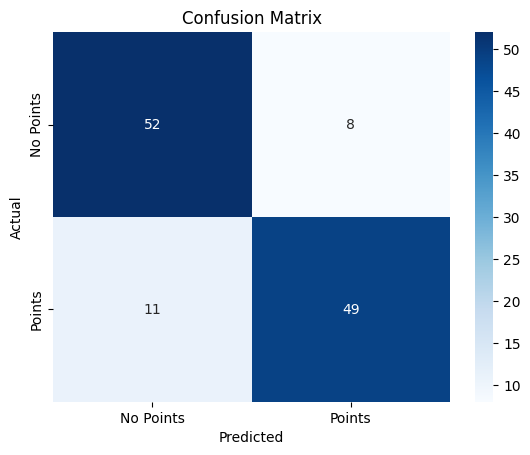

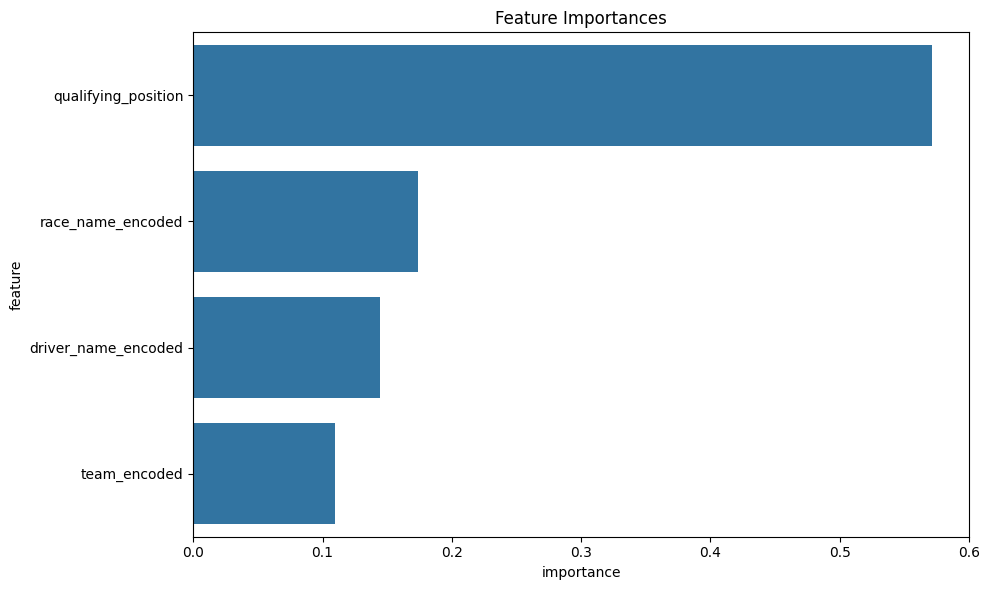


Feature Importances:
               feature  importance
0  qualifying_position    0.571743
3    race_name_encoded    0.173909
1  driver_name_encoded    0.144728
2         team_encoded    0.109620


In [9]:

# %%
if model and not X_test.empty and not y_test.empty:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Points', 'Points'], yticklabels=['No Points', 'Points'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Feature Importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': final_feature_columns, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df)
        plt.title('Feature Importances')
        plt.tight_layout()
        plt.show()
        print("\nFeature Importances:")
        print(feature_importance_df)

elif not model:
     print("Model was not trained. Evaluation skipped.")
else:
    print("Test data is empty. Evaluation skipped.")


In [10]:

def predict_hypothetical_race(model, race_data_hypothetical, label_encoders_dict, feature_cols):
    """
    Predicts outcomes for hypothetical race data.

    Args:
        model: The trained scikit-learn model.
        race_data_hypothetical (pd.DataFrame): DataFrame with future race data.
            Required columns: 'qualifying_position', 'driver_name', 'team', 'race_name'.
        label_encoders_dict (dict): Dictionary of fitted LabelEncoders.
        feature_cols (list): List of feature column names used for training.

    Returns:
        pd.DataFrame: Input DataFrame with added 'predicted_points_finish' and 'prediction_probability_points'.
    """
    if model is None:
        print("Model is not available for prediction.")
        return race_data_hypothetical
    
    if race_data_hypothetical.empty:
        print("Hypothetical race data is empty.")
        return race_data_hypothetical

    data_to_predict = race_data_hypothetical.copy()

    # Encode categorical features
    for col, le in label_encoders_dict.items():
        encoded_col_name = col + '_encoded'
        if col in data_to_predict.columns:
            # Handle unseen labels: map them to a new category (e.g., -1 or len(classes))
            # or use a strategy like 'ignore' if the encoder supports it, or retrain.
            # For simplicity, we'll try to transform and catch errors for unseen.
            try:
                data_to_predict[encoded_col_name] = le.transform(data_to_predict[col])
            except ValueError as e:
                print(f"Warning for column '{col}': {e}. Unseen labels might be present.")
                # Option: assign a default category (e.g., a new index or -1)
                # This requires knowing the range of existing encoded values.
                # For now, we'll let it be NaN or error out if not handled by model.
                # A robust solution would involve updating encoders or using a specific strategy.
                data_to_predict[encoded_col_name] = -1 # Placeholder for unknown
        elif encoded_col_name in feature_cols : # If the _encoded col is a feature but original is missing
             print(f"Warning: Original column '{col}' for encoding '{encoded_col_name}' not in hypothetical data.")
             data_to_predict[encoded_col_name] = -1 # Placeholder

    # Ensure all feature columns are present
    X_hypothetical = data_to_predict[feature_cols].copy()
    
    # Handle any NaNs that might result from failed encoding or missing data
    # (e.g. if qualifying_position was not provided)
    for fc in feature_cols:
        if fc not in X_hypothetical.columns:
            print(f"Critical feature {fc} missing from hypothetical data after encoding. Setting to 0/default.")
            X_hypothetical[fc] = 0 # Or an appropriate default like mean from training
        elif X_hypothetical[fc].isnull().any():
            print(f"NaNs found in feature {fc}. Filling with 0/default.")
            X_hypothetical[fc].fillna(0, inplace=True) # Or an appropriate default


    # Make predictions
    predictions = model.predict(X_hypothetical)
    probabilities = model.predict_proba(X_hypothetical)

    race_data_hypothetical['predicted_points_finish'] = predictions
    # Probability of finishing in points (class 1)
    if probabilities.shape[1] > 1:
        race_data_hypothetical['prediction_probability_points'] = probabilities[:, 1] 
    else: # Handle case where model only predicts one class (e.g. due to imbalanced data or simple model)
        race_data_hypothetical['prediction_probability_points'] = probabilities[:, 0] if model.classes_[0] == 1 else 1 - probabilities[:, 0]


    return race_data_hypothetical


In [11]:
if model and 'race_name' in label_encoders and 'driver_name' in label_encoders and 'team' in label_encoders:
    # Pick a race name that was in the training data for encoding
    sample_race_name = label_encoders['race_name'].classes_[0] if len(label_encoders['race_name'].classes_) > 0 else "Unknown Race"
    
    # Pick some drivers and teams that were in the training data
    sample_drivers = list(label_encoders['driver_name'].classes_[:5]) if len(label_encoders['driver_name'].classes_) >=5 else list(label_encoders['driver_name'].classes_)
    sample_teams = list(label_encoders['team'].classes_[:5]) if len(label_encoders['team'].classes_) >=5 else list(label_encoders['team'].classes_)

    if not sample_drivers or not sample_teams:
        print("Not enough unique drivers/teams in training data to create a hypothetical example.")
    else:
        hypothetical_race_entries = []
        for i, driver in enumerate(sample_drivers):
            # Cycle through teams for variety if fewer teams than drivers
            team = sample_teams[i % len(sample_teams)]
            hypothetical_race_entries.append({
                'driver_name': driver,
                'team': team,
                'race_name': sample_race_name, # Use a race known to the encoder
                'qualifying_position': i + 1  # Example qualifying positions 1, 2, 3, ...
            })

        hypothetical_race_df = pd.DataFrame(hypothetical_race_entries)

        print("\nSample Hypothetical Race Data (Input for 2025 prediction):")
        print(hypothetical_race_df)

        # Make predictions
        if not hypothetical_race_df.empty:
            predictions_2025_df = predict_hypothetical_race(model, hypothetical_race_df, label_encoders, final_feature_columns)
            print("\nPredictions for Hypothetical 2025 Race:")
            print(predictions_2025_df[['driver_name', 'team', 'qualifying_position', 'predicted_points_finish', 'prediction_probability_points']])
        else:
            print("Hypothetical race DataFrame is empty, cannot make predictions.")
else:
    print("\nSkipping hypothetical prediction example because model or label encoders are not available.")
    if not model: print(" - Model not trained.")
    if 'race_name' not in label_encoders : print(" - Race name encoder missing.")
    if 'driver_name' not in label_encoders : print(" - Driver name encoder missing.")
    if 'team' not in label_encoders : print(" - Team encoder missing.")


# %% [markdown]
# ## 6. Further Improvements & Considerations
#
# * **More Data:** Use data from many more past seasons.
# * **Advanced Features:**
#     * Driver historical performance (avg. points, recent form).
#     * Team historical performance.
#     * Track-specific performance for drivers/teams.
#     * Lap times from practice/qualifying sessions.
#     * Pit stop data.
#     * Weather conditions.
#     * Tyre compounds.
# * **More Sophisticated Models:** Gradient Boosting (XGBoost, LightGBM), Neural Networks.
# * **Handling New Entities:** Develop a robust strategy for new drivers, teams, or tracks not seen in training data.
# * **Hyperparameter Tuning:** Optimize your model's parameters.
# * **Cross-Validation:** Use more robust validation techniques like time-series cross-validation.
# * **Predicting Exact Position:** This is much harder and would likely require a regression model and more detailed features.
# * **Dynamic Updates:** For a live season, you'd retrain your model as new race data becomes available.

# %%
print("\nNotebook execution finished.")


Sample Hypothetical Race Data (Input for 2025 prediction):
        driver_name                          team  race_name  \
0   Alexander Albon                Alpine Renault  COM MIAMI   
1      Carlos Sainz  Aston Martin Aramco Mercedes  COM MIAMI   
2   Charles Leclerc                       Ferrari  COM MIAMI   
3  Daniel Ricciardo                  Haas Ferrari  COM MIAMI   
4      Esteban Ocon           Kick Sauber Ferrari  COM MIAMI   

   qualifying_position  
0                    1  
1                    2  
2                    3  
3                    4  
4                    5  

Predictions for Hypothetical 2025 Race:
        driver_name                          team  qualifying_position  \
0   Alexander Albon                Alpine Renault                    1   
1      Carlos Sainz  Aston Martin Aramco Mercedes                    2   
2   Charles Leclerc                       Ferrari                    3   
3  Daniel Ricciardo                  Haas Ferrari                   